# Skin lesion classification

**Deadline**: Upload this notebook (rename it as 'TP-SVM-YOUR-SURNAME.ipynb') to Ecampus before the deadline.


**Context**
A skin lesion is defined as a superficial growth or patch of the skin that is visually different and/or has a different texture than its surrounding area. Skin lesions, such as moles or birthmarks, can degenerate and become melanoma, one of the deadliest skin cancer. Its incidence has been increasing during the last decades, especially in the areas mostly populated by white people.

The most effective treatment is an early detection followed by surgical excision. This is why several approaches for melanoma detection have been proposed in the last years (non-invasive computer-aided diagnosis (CAD) ).


**Goal**
The goal of this practical session is to classify images of skin lesions as either benign or melanoma using machine learning algorithms. In order to do that, you will have at your disposal a set of 30 features already extracted from 600 dermoscopic images (both normal skin lesions and melanoma from the ISIC database - https://isic-archive.com/). These features characterize the Asymmetry, the Border irregularity, the Colour and the Dimension of the lesion (the so-called ABCD rule). 

The features are:
- shape asimmetry (f0 and f1)
- difference in colors between center and periphery of the image (f2, f3, f4, f27, f28, f29)
- geometry (f5, f6, f7)
- other features related to eccentricity,entropy, mean, standard deviation and maximum value of each channel in RGB and HSV (f8,...,f24)
- asimmetry of color intensity (f25, f26)

Features are computed using *manually checked segmentations* and following *Ganster et al. 'Automated melanoma recognition', IEEE TMI, 2001* and *Zortea et al. 'Performance of a dermoscopy-based computer vision system for the diagnosis of pigmented skin lesions compared with visual evaluation by experienced dermatologists', Artificial Intelligence in Medicine, 2014*.

First load all necessary packages

In [1]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  cross_val_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, KFold, cross_validate
from sklearn.linear_model import Perceptron
from sklearn.decomposition import PCA

%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# Code from scikit-learn
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > 0.5 else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Then load the data from my Google Drive

Or from yout local computer. Please download the 'data' folder in the same folder as your notebook and do not modifiy it.

Then read the data 

In [2]:
## Read data
Working_directory="./data/data/" 
df = pd.read_csv(Working_directory + 'features.csv') # reading data
y = df['Malignant'].values # 1 for Melanoma and 0 for healthy
class_names = ["healthy","melanoma"]
X = df.iloc[:,3:33].values # Features
N,M=X.shape
print('Number of images: {0}; Number of features per image: {1}'.format(N,M))
print('Number of healthy nevus: {0}; Number of melanoma: {1}'.format(N-np.sum(y), np.sum(y)))


Number of images: 600; Number of features per image: 30
Number of healthy nevus: 485; Number of melanoma: 115


Two examples of healthy nevus and melanoma


Text(0.5, 1.0, 'Segmented melanoma')

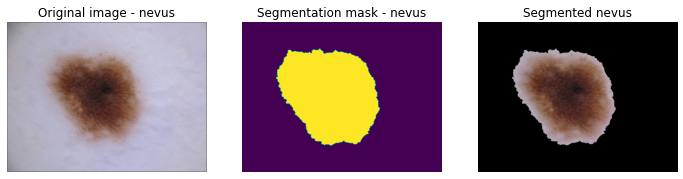

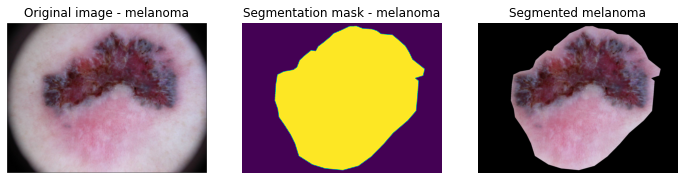

In [3]:
## Plot two examples of nevus and melanoma
print('Two examples of healthy nevus and melanoma')
nevus = imread(Working_directory + 'im/nevus.jpg')
nevus_Segmentation = imread(Working_directory + 'im/nevus-seg.jpg') 
nevus_Segmentation_boolean = (nevus_Segmentation/255).astype(np.uint8) # To get uint8 (integer numbers)
nevus_Segmentation_3D = np.expand_dims(nevus_Segmentation_boolean, axis=2) # To have a binary mask for the three channels (RGB)
nevus_mul_mask = (nevus_Segmentation_3D*nevus) # we apply the binary mask to all channels pixel-wise

fig = plt.figure(figsize=(12, 12)) # size of the figure
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5) # code to create subplots
grid[0].imshow(nevus)
grid[0].axis('off')
grid[0].set_title('Original image - nevus')
grid[1].imshow(nevus_Segmentation)
grid[1].axis('off')
grid[1].set_title("Segmentation mask - nevus")
grid[2].imshow(nevus_mul_mask)
grid[2].axis('off')
grid[2].set_title("Segmented nevus")

###

melanoma = imread(Working_directory + 'im/melanoma.jpg')
melanoma_Segmentation = imread(Working_directory + 'im/melanoma-seg.jpg') 
melanoma_Segmentation_boolean = (melanoma_Segmentation/255).astype(np.uint8) # To get uint8 (integer numbers)
melanoma_Segmentation_3D = np.expand_dims(melanoma_Segmentation_boolean, axis=2) # To have a binary mask for the three channels (RGB)
melanoma_mul_mask = (melanoma_Segmentation_3D*melanoma) # we apply the binary mask to all channels pixel-wise

fig = plt.figure(figsize=(12, 12)) # size of the figure
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5) # code to create subplots
grid[0].imshow(melanoma)
grid[0].axis('off')
grid[0].set_title('Original image - melanoma')
grid[1].imshow(melanoma_Segmentation)
grid[1].axis('off')
grid[1].set_title("Segmentation mask - melanoma")
grid[2].imshow(melanoma_mul_mask)
grid[2].axis('off')
grid[2].set_title("Segmented melanoma")


Now, as in the previous practical session you should shuffle the data randomly

In [4]:
# Shuffle data randomly
i= np.random.randint(100)
np.random.seed(i)
Xp=np.random.permutation(X)
np.random.seed(i)
yp=np.random.permutation(y)

We should now test the discriminative power of our features. Fist, let divide the entire data-set into training and test set using the `stratify` option. This will preserve the original proportion between nevus and melanoma also in the training and test set. You can check that from the plot.

Text(0, 0.5, 'Proportion')

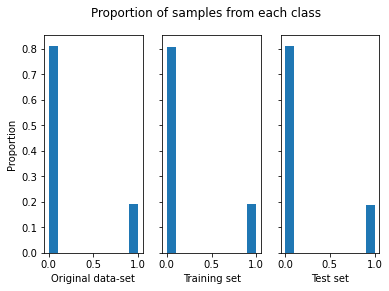

In [5]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(Xp, yp, test_size=0.3, random_state=42,stratify=yp)

fig, axs = plt.subplots(1, 3, sharey=True)
fig.suptitle('Proportion of samples from each class')
axs[0].hist(yp,weights=np.ones_like(yp)/len(yp))
axs[0].set_xlabel('Original data-set')
axs[1].hist(y_train,weights=np.ones_like(y_train)/len(y_train))
axs[1].set_xlabel('Training set')
axs[2].hist(y_test,weights=np.ones_like(y_test)/len(y_test))
axs[2].set_xlabel('Test set')
axs[0].set_ylabel('Proportion')

As we have already seen, it might be very important to scale the data such that each feature has, for instance, average equal to 0 and unit variance. Which is the right way of doing it when having a training and a test set in your opinion ? Should you use together both training and test set ?

Si on fait de la cross-validation sur l'ensemble des données il est préférable de normaliser les données entières mais si on n'est pas dans ce cas il vaut mieux normaliser séparément car il faut que le test set soit totalement indépendant du train set. 

In [6]:
# Scale data (each feature will have average equal to 0 and unit variance)
scaler = StandardScaler()
scaler.fit(Xp)
X_scale=scaler.transform(Xp)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(Xp, yp, test_size=0.3, random_state=42,stratify=yp)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)

scaler = StandardScaler()
scaler.fit(X_test)
X_test_sc = scaler.transform(X_test)

Now, use two simple classification algorithms, for instance LDA and QDA, and look at the confusion matrices. 

**Question**: Comment the results. 

Fitting LDA to training set
              precision    recall  f1-score   support

           0       0.86      0.94      0.90       146
           1       0.57      0.35      0.44        34

    accuracy                           0.83       180
   macro avg       0.72      0.65      0.67       180
weighted avg       0.81      0.83      0.81       180

Normalized confusion matrix
[[0.93835616 0.06164384]
 [0.64705882 0.35294118]]


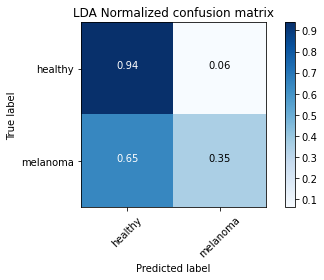

Fitting QDA to training set
              precision    recall  f1-score   support

           0       0.84      0.95      0.89       146
           1       0.50      0.24      0.32        34

    accuracy                           0.81       180
   macro avg       0.67      0.59      0.61       180
weighted avg       0.78      0.81      0.78       180

Normalized confusion matrix
[[0.94520548 0.05479452]
 [0.76470588 0.23529412]]


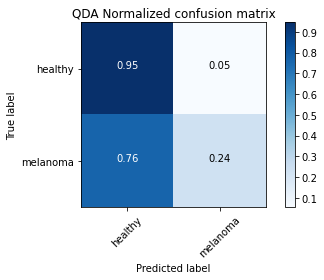

In [8]:
# Fitting LDA
print("Fitting LDA to training set")
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_sc, y_train)
y_pred = lda.predict(X_test_sc)
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='LDA Normalized confusion matrix')
plt.show()

# Fitting QDA
print("Fitting QDA to training set")
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_sc, y_train)
y_qda_pred =qda.predict(X_test_sc)
print(classification_report(y_test, y_qda_pred))

# Compute confusion matrix
cnf_matrix2 = confusion_matrix(y_test, y_qda_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix2, classes=class_names, normalize=True,
                      title='QDA Normalized confusion matrix')
plt.show()

Les résultats sont bien précis pour prédire les lésions saines mais pas pour les mélanomes. Cela doit être du au fait que dans le train set il y a une majorité de lésion saines donc la prédiction retransmet cette particularité d'avoir une majorité de lésion saines. LDA est légerement plus performant, ainsi il n'est pas utile de considérer les covariances des classes différentes. QDA ici n'a pas d'avantage par rapport à LDA

The results you obtained are based on a precise subdivision of your data into training and test. This can thus bias your results. Which technique could you use instead ? Test it  with LDA, QDA and K-NN.

On peut faire de la cross-validation 


In [9]:
# Fitting LDA
print("Fitting LDA")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda_score = cross_val_score(lda,X=X_scale, y=np.ravel(yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

# Fitting QDA
print("Fitting QDA")
t0 = time()
qda = QuadraticDiscriminantAnalysis()
qda_score = cross_val_score(qda,X=X_scale, y=np.ravel(yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))
# Fitting K-nearest neighbour
print("Fitting K-nearest neighbour")
t0 = time()
neigh = KNeighborsClassifier(n_neighbors=3)
neigh_score = cross_val_score(neigh,X=X_scale, y=np.ravel(yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(neigh_score.mean(), neigh_score.std() ))

Fitting LDA
done in 0.047s
 Average and std CV score : 0.8283333333333334 +- 0.020138409955990935
Fitting QDA
done in 0.023s
 Average and std CV score : 0.805 +- 0.02211083193570265
Fitting K-nearest neighbour
done in 0.063s
 Average and std CV score : 0.8 +- 0.021730674684008838


When using K-NN, instead than fixing the number of nearest neighbours, we could also estimate the best value using Cross Validation. Do it and plot the confusion matrix. Do you notice anything strange ? Why in your opinion do you have this kind of result ?

Best training Score: 0.8285714285714285
Best training params: {'n_neighbors': 5}
Normalized confusion matrix
[[0.89041096 0.10958904]
 [0.70588235 0.29411765]]


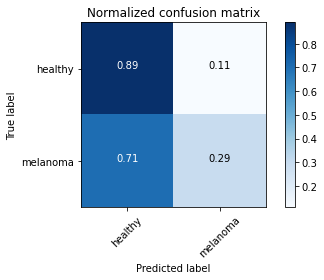

In [10]:
# Looking for the best hyperparameters
p_grid_KNN = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
KNN = KNeighborsClassifier()
grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring="accuracy", cv=5)
grid_KNN.fit(X_train_sc, y_train)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test_sc)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Ici on remarque que l'algorithme sort globalement un seul résultat, celui bénin. Le problème c'est que puisqu'on a beaucoup moins de mélanomes que de lesions bénignes dans l'algorithme de prédiction sort un seul résultat, celui qui correspond à la majorité ("bénin") ce qui donne un bon score, mais le résultat n'est pas du tout satisfaisant.

In order to deal with this problem we have two possible solutions. 

**First**: Please look at this webpage (https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) and try MORE APPROPRIATE scoring functions than accuracy when looking for the best K value of K-NN (thus within the Cross Validation as before..).

Best training Score: 0.3798309516570386
Best training params: {'n_neighbors': 5}
Normalized confusion matrix
[[0.89041096 0.10958904]
 [0.70588235 0.29411765]]


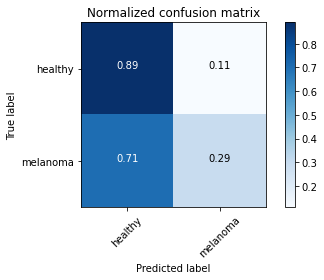

In [11]:
# Looking for the best hyperparameters
from sklearn.metrics import balanced_accuracy_score, make_scorer
p_grid_KNN = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
KNN = KNeighborsClassifier()
grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring='f1', cv=5)
grid_KNN.fit(X_train_sc, y_train)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test_sc)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

On obtient un autre nombre de n_neighbor et le résultat est meilleur qu'avec le score initial, cependant ce n'est toujours pas satisfaisant, il y a beaucoup de faux "healty"

**Second**: when dealing with such a problem (the one you should find !) a possible solution would be to oversample a class (which one in your opinion ?) Please look at this web page for more information (https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html) and try at least one naive random over-sampling (look at the following code...).

In [12]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train_sc, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 339), (1, 339)]


Let's look for the best K in KNN (as before using Cross validation) but this time on the new training set. 

**Question**: Are the results better ? Do they change now if you modify the scoring function ? Why ?

Best training Score: 0.9011546840958605
Best training params: {'n_neighbors': 1}
Normalized confusion matrix
[[0.84931507 0.15068493]
 [0.64705882 0.35294118]]


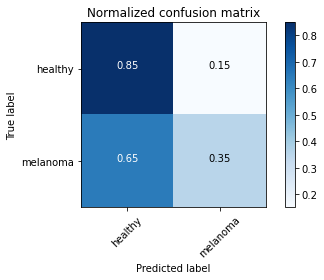

In [13]:
# Looking for the best hyperparameters
p_grid_KNN = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
KNN = KNeighborsClassifier()
grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN, scoring='accuracy', cv=5)
grid_KNN.fit(X_resampled, y_resampled)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test_sc)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Puisqu'on a un nombre de melanome inférieur à cleui de lésions saines, je pense qu'on oversmaple la classe melanome. En calculant l'estimateur en fonction d'un score qui prend en compte ce biais (f1, balanced_accuracy), on a effectivement une meilleure prédiction, il reste cependant encore beaucoup de fausses prédictions.

Let's use the techniques seen today: Perceptron and linear SVM. 

In [14]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = Perceptron()
Perc_cv = cross_validate(Perc,X_scale, yp,cv=5,scoring='accuracy',return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_score'].mean(), Perc_cv['train_score'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_score'].mean(), Perc_cv['test_score'].std() ))


# Fitting linear SVM 
print("Fitting Linear SVM")
Lsvm = LinearSVC() 
Lsvm_cv = cross_validate(Lsvm,X_scale, yp,cv=5,scoring='accuracy',return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_score'].mean(), Lsvm_cv['train_score'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_score'].mean(), Lsvm_cv['test_score'].std() ))

Fitting Perceptron
 Average and std TRAIN CV accuracy : 0.7754166666666668 +- 0.017843844254469894
 Average and std TEST CV accuracy : 0.78 +- 0.03711842908553346
Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.8429166666666668 +- 0.004289845892077902
 Average and std TEST CV accuracy : 0.8200000000000001 +- 0.011303883305208767


We can easily use different scoring functions within the cross validate function of scikit-learn. Check the code.

In [15]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = Perceptron()
Perc_cv = cross_validate(Perc,X_scale, yp,cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(Perc_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))


# Fitting linear SVM 
print("Fitting Linear SVM")
Lsvm = LinearSVC() 
Lsvm_cv = cross_validate(Lsvm,X_scale, yp,cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_accuracy'].mean(), Lsvm_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_accuracy'].mean(), Lsvm_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Lsvm_cv['train_f1'].mean(), Lsvm_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Lsvm_cv['test_f1'].mean(), Lsvm_cv['test_f1'].std() ))


Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.7754166666666668 +- 0.017843844254469894
 Average and std TEST CV accuracy : 0.78 +- 0.03711842908553346
 Average and std TRAIN CV f1 : 0.3817410306839625 +- 0.0962009221314981
 Average and std TEST CV f1 : 0.35536174818089716 +- 0.09471630235646308
Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.84375 +- 0.00527046276694728
 Average and std TEST CV accuracy : 0.8183333333333334 +- 0.009718253158075466
 Average and std TRAIN CV f1 : 0.41771383599139733 +- 0.03282860291779026
 Average and std TEST CV f1 : 0.3150326797385621 +- 0.08685878606281403


**Question** Please do the same on the oversampled data and compare the results with the previous ones.

In [16]:
X_resampled_All, y_resampled_All = ros.fit_resample(X_scale, yp)

# Fitting Perceptron
print("Fitting Perceptron")
Perc = Perceptron()
Perc_cv = cross_validate(Perc,X_resampled_All, y_resampled_All,cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(Perc_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))


# Fitting linear SVM 
print("Fitting Linear SVM")
Lsvm = LinearSVC() 
Lsvm_cv = cross_validate(Lsvm,X_resampled_All, y_resampled_All,cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_accuracy'].mean(), Lsvm_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_accuracy'].mean(), Lsvm_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Lsvm_cv['train_f1'].mean(), Lsvm_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Lsvm_cv['test_f1'].mean(), Lsvm_cv['test_f1'].std() ))


Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.6224226804123711 +- 0.04467766964783432
 Average and std TEST CV accuracy : 0.6288659793814433 +- 0.016939872912530945
 Average and std TRAIN CV f1 : 0.6080091063660269 +- 0.05696947741251637
 Average and std TEST CV f1 : 0.6158749781713813 +- 0.03779746363518649
Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.7213917525773196 +- 0.00787665298450313
 Average and std TEST CV accuracy : 0.7072164948453608 +- 0.046035285694363076
 Average and std TRAIN CV f1 : 0.7067947043800262 +- 0.008514625078474062
 Average and std TEST CV f1 : 0.6923430022384942 +- 0.045689655075098805


On remarque que sans les données oversampled, les scores f1 sont faibles ce qui montre le même problème qu'avec KNN, puisque la classe "healthy" était majoritaire sur le train set l'algorithme va prédire majoritairement des lésions saines.

Après avoir "oversmapled" les données on trouve que le accuracy score est un peu plus faible mais le scoring f1 est beaucoup plus élevé qu'avant. Ainsi on a reglé ce biais de classe majoritaire.

We can also ask to save the estimated models at each split (i.e. fold) with the option `return_estimator=True`. Using the perceptron, we will look for the best model using the oversampled training data and check the confusion matrix on the test data. 

**Question** Do it the same with the linear SVM.

Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.6685307129314386 +- 0.03984347380417917
 Average and std TEST CV accuracy : 0.6267755991285403 +- 0.05688363667670765
 Average and std TRAIN CV f1 : 0.6814553039229376 +- 0.03831455618425962
 Average and std TEST CV f1 : 0.6463211991161175 +- 0.04462009013726829
Normalized confusion matrix
[[0.64383562 0.35616438]
 [0.44117647 0.55882353]]


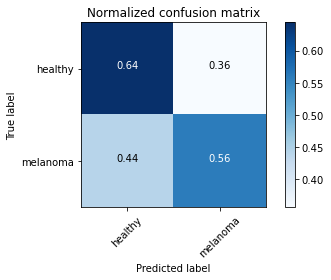

Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.7466786270072646 +- 0.003971668244107267
 Average and std TEST CV accuracy : 0.7241503267973857 +- 0.017171280728153746
 Average and std TRAIN CV f1 : 0.7343669881492876 +- 0.006790399165506062
 Average and std TEST CV f1 : 0.7093013149024525 +- 0.025198398925745182
Normalized confusion matrix
[[0.74657534 0.25342466]
 [0.35294118 0.64705882]]


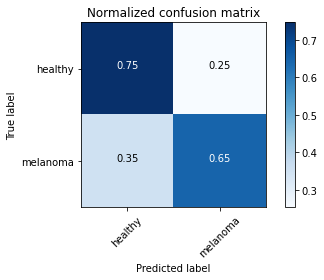

In [17]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = Perceptron()
Perc_cv = cross_validate(Perc,X_resampled, y_resampled,cv=5,scoring=('accuracy', 'f1'),return_train_score=True,return_estimator=True)
print(Perc_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))

# Look for the best estimator (the one with the greatest test accuracy)
index_best = np.argmax(Perc_cv['test_accuracy'])
estimator_best=Perc_cv['estimator'][index_best]
y_pred = estimator_best.predict(X_test_sc)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()


# Fitting linear SVM 
print("Fitting Linear SVM")
Lsvm = LinearSVC() 
Lsvm_cv = cross_validate(Lsvm,X_resampled, y_resampled,cv=5,scoring=('accuracy', 'f1'),return_train_score=True,return_estimator=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_accuracy'].mean(), Lsvm_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_accuracy'].mean(), Lsvm_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Lsvm_cv['train_f1'].mean(), Lsvm_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Lsvm_cv['test_f1'].mean(), Lsvm_cv['test_f1'].std() ))


# Look for the best estimator (the one with the greatest test accuracy)
index_best = np.argmax(Lsvm_cv['test_accuracy'])
estimator_best=Lsvm_cv['estimator'][index_best]
y_pred = estimator_best.predict(X_test_sc)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Les résultats sont très satisfaisants.

Suppose that there are overlapping classes, we need to set the hyper-parameter C for the SVM model. 

**Question** Use Cross-Validation on the oversampled data to find the best C value. Plot the confusion matrix using the best estimator (as before).

Best training Score: 0.719799023733734
Best training params: {'C': 3}
Normalized confusion matrix
[[0.76712329 0.23287671]
 [0.38235294 0.61764706]]


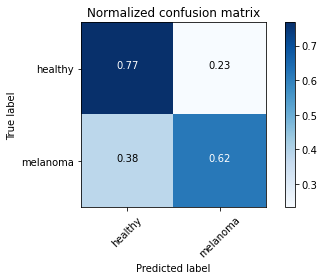

In [18]:
# Looking for the best hyperparameter C 
p_grid_lsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}
Lsvm = LinearSVC()
grid_lsvm = GridSearchCV(estimator= Lsvm,param_grid=p_grid_lsvm, scoring='f1', cv=5 )
grid_lsvm.fit(X_resampled, y_resampled)
print("Best training Score: {}".format(grid_lsvm.best_score_))
print("Best training params: {}".format(grid_lsvm.best_params_))
y_pred = grid_lsvm.predict(X_test_sc)
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Here it is the code for non-linear SVM using radial basis function. We need to tune another hyper-parameter $gamma$. We look for the best $C$ and $gamma$ at the same time.

**Question** Use Cross-Validation on the oversampled data to find the best C and $gamma$ value. Plot the confusion matrix using the best estimator (as before).

Fitting Non-linear SVM to the training set
Best training Score: 0.8404761904761905
Best training params: {'C': 4, 'gamma': 0.005}
Normalized confusion matrix
[[0.99315068 0.00684932]
 [0.76470588 0.23529412]]


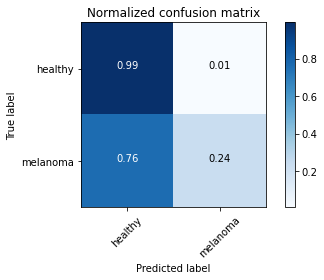

In [19]:
# Fitting Non-linear SVM
print("Fitting Non-linear SVM to the training set")
t0 = time()
p_grid_nlsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
NLsvm = SVC(kernel='rbf')
grid_nlsvm = GridSearchCV(estimator= NLsvm,param_grid=p_grid_nlsvm, scoring='accuracy', cv=5 )
grid_nlsvm.fit(X_train_sc, y_train)
print("Best training Score: {}".format(grid_nlsvm.best_score_))
print("Best training params: {}".format(grid_nlsvm.best_params_))
y_pred = grid_nlsvm.predict(X_test_sc)
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

**Question** Use the non-linear SVM with the two strategies seen before (different scoring function and/or oversampled data). Do the results change ? Why in your opinion ?

Fitting Non-linear SVM to the training set
Best training Score: 0.97253258840642
Best training params: {'C': 3, 'gamma': 0.1}
Normalized confusion matrix
[[0.94520548 0.05479452]
 [0.82352941 0.17647059]]


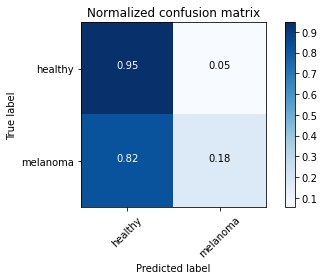

In [20]:
print("Fitting Non-linear SVM to the training set")
t0 = time()
p_grid_nlsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
NLsvm = SVC(kernel='rbf')
grid_nlsvm = GridSearchCV(estimator= NLsvm,param_grid=p_grid_nlsvm, scoring='f1', cv=5 )
grid_nlsvm.fit(X_resampled, y_resampled)
print("Best training Score: {}".format(grid_nlsvm.best_score_))
print("Best training params: {}".format(grid_nlsvm.best_params_))
y_pred = grid_nlsvm.predict(X_test_sc)
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Les résultats sont mauvais même si on a un très bon score, et oversample les données ou changer de scoring n'a pas d'impact, peut-être parce que ce biais ici de prédire majoritairement des lésion saines n'est pas dû aux données du train set mais à l'aspect non-lineaire de l'algorithme

**Question** Try to draw a conclusion from the different experiments. Which is the best method ? Which scoring function should you use ? Is it worth it to oversample one of the two classes ?

Ici le meilleur résultat est donné par Perceptron ou linear SVM quand les données sont oversampled et en cross validation sur C pour linear SVM. Je pense qu'il faut effectivement vérifier avec les deux type de scoring (f1 et accuracy) pour vérifier qu'il n'y est un biais dû aux données dy train set. Si dans le train set il y a une classe majoritaire il est préférable d'oversample la classe minoritaire.

**OPTIONAL** Another interesting question is: what about the number of features ? Can we reduce the dimensionality ? You could use one of the techniques seen during the previous lectures (i.e. PCA) ...

In [21]:
# Test PCA with a linear SVM
pca = PCA(random_state=1)
Ypca=pca.fit_transform(X_scale)
var_explained_pca=pca.explained_variance_ratio_
index_90 = np.where(np.cumsum(var_explained_pca)>0.90)[0][0]

print("New number of features :",index_90)
X_pca = Ypca[:,:index_90]
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, yp, test_size=0.3, random_state=42,stratify=yp)


ros = RandomOverSampler(random_state=0)
X_resampled_pca, y_resampled_pca = ros.fit_resample(X_train_pca, y_train_pca)
print(sorted(Counter(y_resampled_pca).items()))

New number of features : 11
[(0, 339), (1, 339)]


Best training Score: 0.6757575757575758
Best training params: {'C': 0.001}
Normalized confusion matrix
[[0.71232877 0.28767123]
 [0.32352941 0.67647059]]


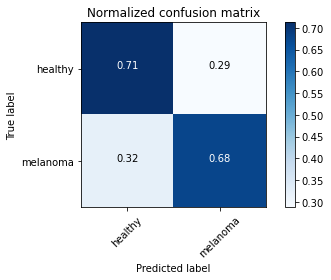

In [22]:
# Fitting Linear SVM 
p_grid_lsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}
Lsvm = LinearSVC()
grid_lsvm = GridSearchCV(estimator= Lsvm,param_grid=p_grid_lsvm, scoring='f1', cv=5 )
grid_lsvm.fit(X_resampled_pca, y_resampled_pca)
print("Best training Score: {}".format(grid_lsvm.best_score_))
print("Best training params: {}".format(grid_lsvm.best_params_))
y_pred = grid_lsvm.predict(X_test_pca)
cnf_matrix = confusion_matrix(y_test_pca, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

**OPTIONAL** ... or test the importance of the single features.
The more naive technique would be to test each feature independently in a greedy fashion called sequential forward feature selection. Starting from an empty set and a classification model, you will first add the feature that maximizes a certain criterion (i.e. f1 score). Then, you will iterate this process until a chosen stopping criterion by adding at each iteration only the best feature. Each feature can be added of course only once. You could also use the opposite process by removing at each iteraton the least important feature starting from the entire set of features (i.e. sequential backward feature selection). Implement at least one of these ideas. 

In [23]:
# Implement forward feature selection and/or backward feature selection
# with a linear SVM

#XXXXXXXXXX